## Bayesian convnet on MNIST dataset

Example based on Yarin Gal's code https://github.com/yaringal/acquisition_example

Compute different acquisition functions to be used for active learning

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
import pylab
%matplotlib inline

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [3]:
model = load_model('MNIST_model.h5')

In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

![title](MNIST_model.png)

In [5]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0295555875858
Test accuracy: 0.9917


# Generate MC samples using keras: 
(we're doing this for the entire test set at once, which requires quite a bit of memory; might be smarter to do this in smaller chunks)

In [54]:
import numpy as np
nb_MC_samples = 100
MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

learning_phase = True  # use dropout at test time

In [56]:
print(x_test.shape)

(10000, 28, 28, 1)


In [57]:
# Batches of 100 elements
MC_samples = np.empty((nb_MC_samples,10000,10))
for i in xrange(100):
    start = i*100
    end = (i+1)*100
    MC_samples[:,start:end,:] = [MC_output([x_test[start:end,:,:,:], learning_phase])[0] for _ in xrange(nb_MC_samples)]

# Predictive entropy

$H(y | x, D_{train}) := - \sum_{c} p(y = c | x, D_{train} ) \log p(y = c | x, D_{train} )$

In [104]:
p_y_c = np.mean(MC_samples, axis=0)
log_p_y_c = np.log(p_y_c)
pred_entropy = - np.sum(np.log(p_y_c + 1e-10)*p_y_c, axis = 1)

### Most confusing test images according to predictive entropy

index:  3060 , acq value:  1.74434770668 prediction:  7 real:  9


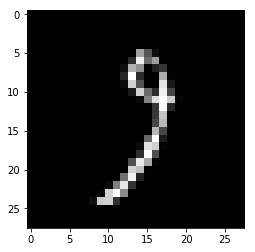

index:  3778 , acq value:  1.72948284153 prediction:  5 real:  5


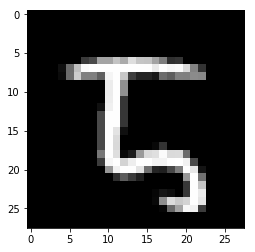

index:  1247 , acq value:  1.65707124214 prediction:  5 real:  9


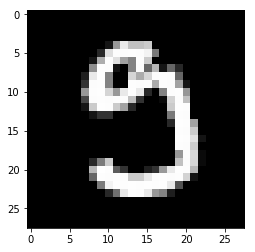

index:  6173 , acq value:  1.62048546284 prediction:  8 real:  9


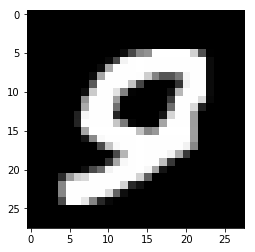

index:  6625 , acq value:  1.60598953426 prediction:  2 real:  8


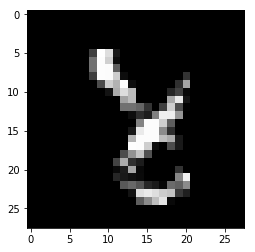

In [105]:
for ind in pred_entropy.argsort()[::-1][:5]:  # get the 5 points with highest entropy value
    probs_ind = np.mean(MC_samples[:,ind,:], axis = 0)
    pred_ind = np.argmax(probs_ind)
    real_ind = np.argmax(y_test[ind])
    print('index: ', ind, ', acq value: ', pred_entropy[ind], 'prediction: ', pred_ind, 'real: ', real_ind)
    pylab.imshow(x_test[ind].squeeze(), cmap="gray")
    pylab.show()

# Variation ratios

$variation ratio = 1 - \max_y p(y | x, D_{train})$

In [110]:
var_ratios = 1 - np.max(p_y_c, axis = 1)

(10000, 10)
(10000,)


### Most confusing test images according to variation ratios

index:  1247 , acq value:  0.703510565768 prediction:  5 real:  9


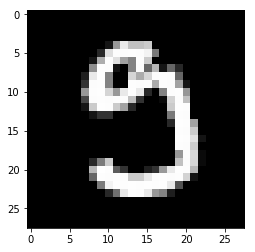

index:  6173 , acq value:  0.664142552163 prediction:  8 real:  9


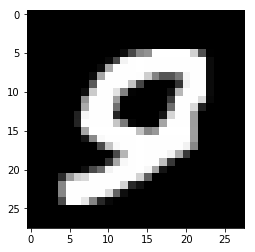

index:  3778 , acq value:  0.661256887836 prediction:  5 real:  5


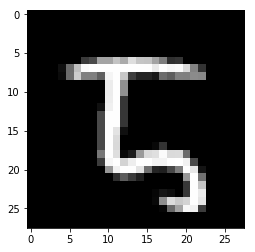

index:  6571 , acq value:  0.654360127002 prediction:  9 real:  9


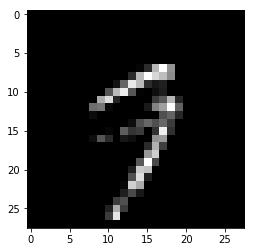

index:  2927 , acq value:  0.622107671671 prediction:  7 real:  3


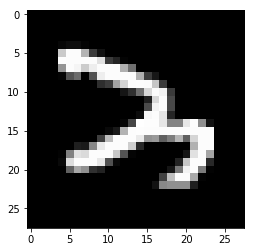

In [111]:
for ind in var_ratios.argsort()[::-1][:5]:  # get the 5 points with highest variation ratio value
    probs_ind = np.mean(MC_samples[:,ind,:], axis = 0)
    pred_ind = np.argmax(probs_ind)
    real_ind = np.argmax(y_test[ind])
    print('index: ', ind, ', acq value: ', var_ratios[ind], 'prediction: ', pred_ind, 'real: ', real_ind)
    pylab.imshow(x_test[ind].squeeze(), cmap="gray")
    pylab.show()

# Approximate the BALD acquisition function:

In [106]:
expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
#expected_p = np.mean(MC_samples, axis=0)
#entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
# BALD_acq = entropy_expected_p - expected_entropy
BALD_acq = pred_entropy - expected_entropy
print('BALD_acq on first 10 points', BALD_acq[:10])

BALD_acq on first 10 points [  2.41600841e-05   4.24614647e-03   1.12051075e-04   5.30551102e-04
   2.98711547e-04   1.70104908e-04   1.06851175e-02   1.25812030e-02
   3.22644144e-01   1.55881633e-03]


### Most confusing test images according to BALD

index:  4205 , acq value:  0.769395138396 prediction:  2 real:  2


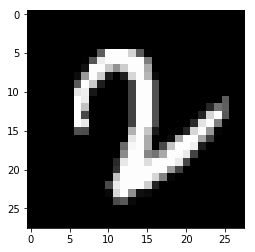

index:  1247 , acq value:  0.727991531196 prediction:  5 real:  9


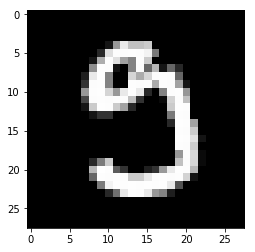

index:  646 , acq value:  0.715771889909 prediction:  2 real:  2


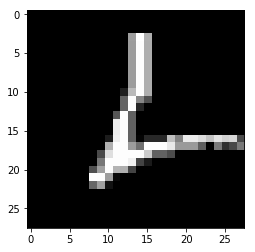

index:  9634 , acq value:  0.69504487946 prediction:  0 real:  0


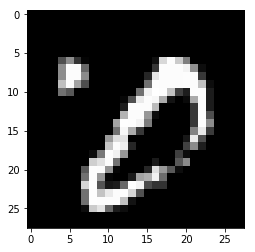

index:  4075 , acq value:  0.667445256279 prediction:  0 real:  8


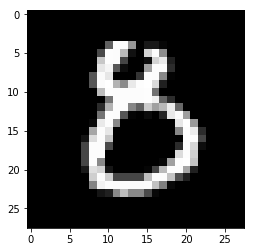

In [112]:
for ind in BALD_acq.argsort()[::-1][:5]:  # get the 5 points with highest BALD_acq value
    probs_ind = np.mean(MC_samples[:,ind,:], axis = 0)
    pred_ind = np.argmax(probs_ind)
    real_ind = np.argmax(y_test[ind])
    print('index: ', ind, ', acq value: ', BALD_acq[ind], 'prediction: ', pred_ind, 'real: ', real_ind)
    pylab.imshow(x_test[ind].squeeze(), cmap="gray")
    pylab.show()